# Discretization-Dependent Dissolution of Self-Organization for Gliders in (Disc)Continuous Cellular Automata


In [ ]:
import numpy as np 
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["animation.embed_limit"] = 128

from yuca.code import CODE
from yuca.ca.continuous import CCA
from yuca.ca.neural import NCA

from yuca.zoo.librarian import Librarian

from notebook_helpers import *

import IPython


In [ ]:
# Newton's law of gravitation
#  f = G (m1 * m2) / r^2
# G = 6.674×10−11 m3⋅kg−1⋅s−2

def gravity_force(positions):
    # 2D gravity demo
    # all bodies are particles with mass 10^6 kg
    
    G = 6.674e-13 # m**3 * kg**(-1) * s**(-2)
    epsilon = 1e-12
    forces = []
    for ii, position_a in enumerate(positions):
        force = np.zeros(2,)
        for jj, position_b in enumerate(positions):
            if ii != jj:
                
                dxy = -(position_a - position_b)
                r2 = np.sum((position_a - position_b)**2)

                
                #print(dxy)
                #force calculated for m1 = m2 = one million kg 
                force += dxy * (G *10**12 / r2)
                
        forces.append(force)
    
    # returned values for force are in Newtons
    return np.array(forces)

def gravity_velocity(positions, velocities):
    
    forces = gravity_force(positions)
   
    # million kg particle masses
    new_velocities = velocities + (forces * 10.**(-6))
    
    return new_velocities

def gravity_update(state):
    
    update = np.zeros_like(state)
    
    update[1] = gravity_velocity(state[0], state[1])
    update[0] = state[0] + update[1]
    
    return state - update
    
def two_body_trajectory(initial_state, my_h, max_h):
    
    new_state = static_update(initial_state, gravity_update, h=my_h)

    x_a = []
    y_a = []
    x_b = []
    y_b = []
    total_h = 0.0

    while total_h < max_h:
        new_state = static_update(new_state, gravity_update, h=my_h)

        x_a.append(new_state[0,0,0])
        y_a.append(new_state[0,0,1])

        x_b.append(new_state[0,1,0])
        y_b.append(new_state[0,1,1])

        total_h += my_h
        
    return x_a, y_a, x_b, y_b

def static_update(state: np.array, ddt_function: callable, h=0.1):
    
    new_state = state + h * ddt_function(state)
    
    return new_state

def center_of_mass(grid):
    
    xx, yy = np.meshgrid(np.arange(grid.shape[1]), np.arange(grid.shape[0]))
    
    center_x = ((xx*grid) / np.sum(grid)).sum()
    center_y = ((yy*grid) / np.sum(grid)).sum()
    
    return np.array([center_x, center_y])

def ca_trajectory(pattern, metadata, my_dt, max_steps, grid_dims=[96,256]):
    
    ca = CCA()
    ca.restore_config(metadata["ca_config"], verbose=False)
    ca.no_grad()
    ca.set_dt(my_dt)
    
    grid = torch.zeros(1,1, grid_dims[0], grid_dims[1])
    grid[:,:,32:32+pattern.shape[-2], :pattern.shape[-1]] = torch.tensor(pattern)
    grid.requires_grad = False
    
    initial_grid = 1.0 * grid
    
    my_coms = [[],[]]
    for step in range(max_steps):
        
        grid = ca(grid)
        
        if grid.sum():
            com_x, com_y = center_of_mass(grid.squeeze().numpy())
        
            my_coms[0].append(com_x)
            my_coms[1].append(com_y)
        
    final_grid = 1.0 * grid
    
    return my_coms, initial_grid, final_grid

def lorenz(dt, coordinates, parameters=(10, 12, 8./3.)):
    """
    
    """
    
    sigma = parameters[0]
    rho = parameters[1]
    beta = parameters[2]
    
    x, y, z = coordinates[...,0:1], coordinates[...,1:2], coordinates[...,2:3]
    
    while len(dt.shape) < len(x.shape):
        dt = dt[:,None]
    
    new_x = x + dt * ((sigma*(y-x)))
    new_y = y + dt * ((rho*x - x*z - y))
    new_z = z + dt * ((x*y - beta*z))
    
    new_coordinates = np.append(np.append(new_x, new_y, axis=-1),\
        new_z, axis=-1)

    return new_coordinates

## Simulating Physics with ODEs

Using the Euler method, the step size $\Delta t$ is a source of systematic discretization error.

$$
f(t+1) = f(t) + \Delta t \frac{df}{dt}
$$

The practical effect of this is that if the step size is too large, the simulation will be inacurrate with respect to the physical system of interest, in this case gravitational dynamics between two point masses.

In [3]:
positions = np.array([[1, 0], [-1, 0.]])
velocities = np.array([[0., 0.000565], [0, -0.000565]])

initial_state = np.append(positions[None,:,:], velocities[None, :,:], axis=0)

total_h = 0.0
my_h = 0.1
max_h = 32768

my_cmap = plt.get_cmap("magma")
color_a = my_cmap(64)
color_b = my_cmap(192)

xs_a = []
ys_a = []
xs_b = []
ys_b = []
my_hs = []

for my_h in [300, .30, 0.03]:
    x_a, y_a, x_b, y_b = two_body_trajectory(initial_state, my_h, max_h)

    xs_a.append(x_a)
    xs_b.append(x_b)
    ys_a.append(y_a)
    ys_b.append(y_b)
    my_hs.append(my_h)

    
lib = Librarian(verbose=False)

pattern, metadata = lib.load("scutium_gravidus_single000")

coms = []
grids = []
ca_dts = [0.99, 0.3, 0.2]
my_max_steps = [100, 200, 100]

for my_dt, max_steps in zip(ca_dts, my_max_steps):
    grid_dims = [56,256]
    my_coms, initial_grid, final_grid = ca_trajectory(pattern, metadata, my_dt, max_steps, grid_dims)
    
    grids.append([initial_grid, final_grid])
    coms.append(my_coms)
    


/home/rive/Desktop/.desktop/projects/cellular_automata/DisContinuous/yuca/yuca/activations.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameters = torch.tensor(parameters).to(torch.get_default_dtype())


/tmp/ipykernel_11856/554897541.py:129: RuntimeWarning: overflow encountered in multiply
  new_y = y + dt * ((rho*x - x*z - y))
/tmp/ipykernel_11856/554897541.py:130: RuntimeWarning: overflow encountered in multiply
  new_z = z + dt * ((x*y - beta*z))
/tmp/ipykernel_11856/554897541.py:129: RuntimeWarning: invalid value encountered in subtract
  new_y = y + dt * ((rho*x - x*z - y))
/tmp/ipykernel_11856/554897541.py:130: RuntimeWarning: invalid value encountered in add
  new_z = z + dt * ((x*y - beta*z))
/tmp/ipykernel_11856/1899254173.py:115: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/tmp/ipykernel_11856/1899254173.py:165: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


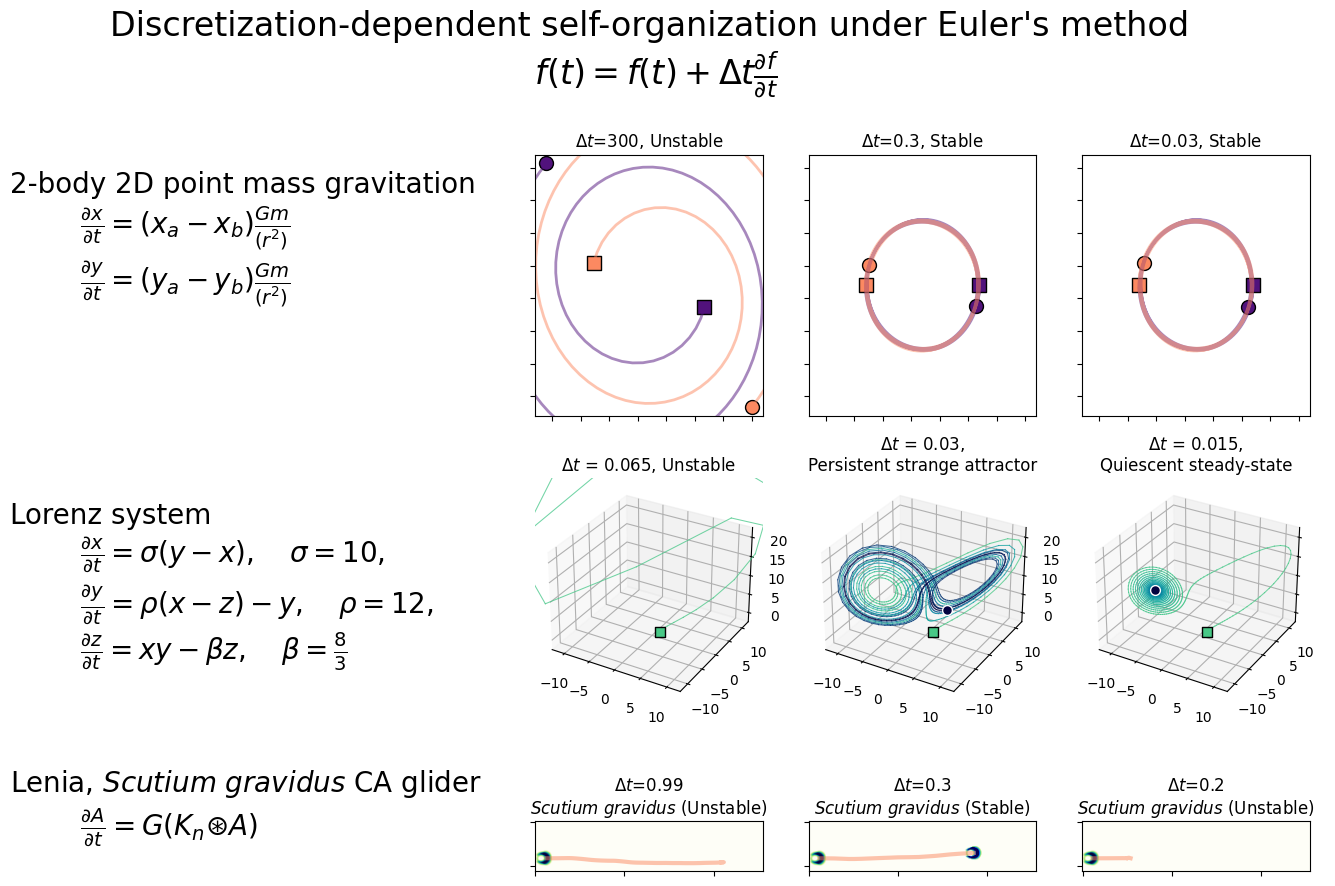

In [4]:
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(3, 3, height_ratios=[1,1,0.6])
axes = []

# 2-body gravitation subplots
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[0,1]))
axes.append(fig.add_subplot(gs[0,2]))

for idx in range(3):

    axes[idx].plot(xs_a[idx], ys_a[idx],\
            lw=2, color=color_a,alpha=0.5)
    axes[idx].scatter(xs_a[idx][-1], ys_a[idx][-1],\
            s=80, color=color_a, edgecolor="k")

    axes[idx].plot(xs_b[idx], ys_b[idx],\
            lw=2, color=color_b,alpha=0.5)

    axes[idx].scatter(xs_b[idx][-1], ys_b[idx][-1],\
            s=80, color=color_b, edgecolor="k")

    axes[idx].scatter(xs_a[idx][0], ys_a[idx][0],\
            marker="s", s=100, color=color_a, edgecolor="k")
    axes[idx].scatter(xs_b[idx][0], ys_b[idx][0],\
            marker="s", s=100, color=color_b, edgecolor="k")
    
    axes[idx].scatter(xs_a[idx][-1], ys_a[idx][-1],\
            marker="o", s=100, color=color_a, edgecolor="k")
    axes[idx].scatter(xs_b[idx][-1], ys_b[idx][-1],\
            marker="o", s=100, color=color_b, edgecolor="k")


    axes[idx].set_xticks(np.arange(-1.7, 2.2, 0.5))
    axes[idx].set_yticks(np.arange(-1.7, 2.2, 0.5))

    axes[idx].set_xticklabels("")
    axes[idx].set_yticklabels("")
    

axes[0].set_title(f"$\Delta t$={my_hs[0]}, Unstable")
axes[1].set_title(f"$\Delta t$={my_hs[1]}, Stable")
axes[2].set_title(f"$\Delta t$={my_hs[2]}, Stable")

#  f = G (m1 * m2) / r^2
# G = 6.674×10−11 m3⋅kg−1⋅s−2

fig.text(-.4,0.7, "2-body 2D point mass gravitation\n"\
         "\t$\\frac{\\partial x}{\\partial t} = (x_a-x_b) \\frac{Gm}{(r^2)}$\n"\
         "\t$\\frac{\\partial y}{\\partial t} = (y_a-y_b) \\frac{Gm}{(r^2)}$\n",\
        fontsize=20)


for ax in axes[0:3]:
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
# Lorenz system subplots
axes.append(fig.add_subplot(gs[1,0], projection='3d'))
axes.append(fig.add_subplot(gs[1,1], projection='3d'))
axes.append(fig.add_subplot(gs[1,2], projection='3d'))

## Lorenz system
dts = np.array([0.065, 0.03, 0.015])
number_steps = 1024
# initial conditions
coordinates_0 = np.array([[1.,1.,-2.]])
# each 
xyzs = [] 

dts = np.array([0.065, 0.03, 0.015])
for idx in range(3,6):

    dt = dts[idx-3:idx-2]
    xyz = coordinates_0*1.0
  
    my_steps = int(number_steps * (dts[1] / dts[idx-3])) 
    
    for my_step in range(my_steps):
        xyz = np.append(xyz, lorenz(dt, xyz[-1:]), axis=0)

    colors = [1.0 - np.array(my_cmap(0.5+0.5*elem/len(xyz))[0:3]) for elem in range(len(xyz))]

    for ii in range(xyz.shape[0]-1):
        axes[idx].plot(*xyz[ii:ii+2].T, lw=0.75, alpha=0.75, color=colors[ii])


    axes[idx].scatter(*xyz[0:1].T, marker="s", s=50, edgecolor="k", color=colors[0])
    axes[idx].scatter(*xyz[-1:].T, marker="o", s=50, edgecolor="w", color=colors[-1])
          
axes[3].set_title(f"$\Delta t$ = {dts[0]}, Unstable")
axes[4].set_title(f"$\Delta t$ = {dts[1]},\nPersistent strange attractor")
axes[5].set_title(f"$\Delta t$ = {dts[2]},\nQuiescent steady-state")

#axes[5].set_zlabel("'\n'\nLorenz system \n$\\sigma = 10$, \n$\\rho=12$, \n$\\beta=\\frac{8}{3}$",\
#        fontsize=16)

fig.text(-.4,0.375, "Lorenz system \n"\
         "\t$\\frac{\\partial x}{\\partial t} =\\sigma (y-x)$,    $\\sigma = 10$, \n"\
         "\t$\\frac{\\partial y}{\\partial t} = \\rho(x-z)-y$,    $\\rho=12$,\n"\
         "\t$\\frac{\\partial z}{\\partial t} = xy - \\beta z$,    $\\beta=\\frac{8}{3}$",\
        fontsize=20)

axes[5].set_zticklabels("")
#fig.text(0.25,0.3,"Lorenz system: $\\sigma = 10$, $\\rho=12$, $\\beta=\\frac{8}{3}$", \
#        fontsize=20)

for ax in axes[3:6]:
    ax.set_xlim(-12, 12)
    ax.set_ylim(-12, 12)
    ax.set_zlim(-2, 22)


plt.tight_layout()
#plt.savefig("summary_figure.png")


# Lenia _Scutium gravidus_ subplots
axes.append(fig.add_subplot(gs[2,0]))
axes.append(fig.add_subplot(gs[2,1]))
axes.append(fig.add_subplot(gs[2,2]))

for idx in range(6,9):
    list_index = idx
    
    my_image_a =  plt.get_cmap("magma")(grids[idx-6][0].squeeze())[:,:,:3]
    my_image_b = plt.get_cmap("inferno")(grids[idx-6][1].squeeze())[:,:,:3]
    
    my_image =1.0 -  (my_image_a + my_image_b)
    
    axes[idx].imshow(my_image)
    
    axes[idx].plot(coms[idx-6][0], coms[idx-6][1],\
            lw=3, color=color_b,alpha=0.5)
    
    #axes[idx].scatter(coms[idx-6][0][-1], coms[idx-6][1][-1],\
    #        s=15, marker="s", color="k", edgecolor="w")
    
    if idx != 7:
        axes[idx].set_title(f"$\Delta t$={ca_dts[idx-6]}"
                "\n$\it{Scutium}$ $\it{gravidus}$ " \
                + f"(Unstable)")
    else:
        axes[idx].set_title(f"$\Delta t$={ca_dts[idx-6]}"
                "\n$\it{Scutium}$ $\it{gravidus}$ " \
                + f"(Stable)")
    
    
    axes[idx].set_xticklabels("")
    axes[idx].set_yticklabels("")

#axes[6].set_ylabel("Lenia (CA)", fontsize=16)
fig.text(-.4,0.2, "Lenia, ${\\it Scutium}$ ${\it gravidus}$ CA glider\n"\
         "\t$\\frac{\\partial A}{\\partial t} = G(K_n \\circledast A)$",\
        fontsize=20)

#fig.suptitle("Self-organization "\
#             "in Euler's method systems\n"\
#             "$f(t+\Delta t) = f(t) + \Delta t (\partial f / \partial t)$", fontsize=24)

fig.text(-0.3, 0.95, "Discretization-dependent self-organization under Euler's method\n"\
         "\t\t\t\t\t$f(t) = f(t) + \\Delta t \\frac{\\partial f}{\\partial t}$",\
         fontsize=24)

plt.tight_layout()
#plt.savefig("summary_figure.png")
plt.show()


In [ ]:
positions = np.array([[1, 0], [-1, 0.]])
velocities = np.array([[0., 0.000565], [0, -0.000565]])

initial_state = np.append(positions[None,:,:], velocities[None, :,:], axis=0)

total_h = 0.0
my_h = 0.1
max_h = 5000

my_cmap = plt.get_cmap("magma")
color_a = my_cmap(64)
color_b = my_cmap(192)

xs_a = []
ys_a = []
xs_b = []
ys_b = []
my_hs = []

for my_h in [300, 3.0, 0.03]:
    x_a, y_a, x_b, y_b = two_body_trajectory(initial_state, my_h, max_h)

    xs_a.append(x_a)
    xs_b.append(x_b)
    ys_a.append(y_a)
    ys_b.append(y_b)
    my_hs.append(my_h)



In [ ]:


lib = Librarian(verbose=False)

pattern, metadata = lib.load("scutium_gravidus_single000")

coms = []
grids = []
dts = [0.99, 0.3, 0.2]
my_max_steps = [100, 200, 100]


for my_dt, max_steps in zip(dts, my_max_steps):
    
    my_coms, initial_grid, final_grid = ca_trajectory(pattern, metadata, my_dt, max_steps)
    
    grids.append([initial_grid, final_grid])
    coms.append(my_coms)
    

    

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(8,10), gridspec_kw={"width_ratios": [.5, 1]})    
#plt.figure()
column = 0
for row in range(3):
    list_index = row + column*3

    axes[row, column].plot(xs_a[list_index], ys_a[list_index],\
            lw=4, color=color_a,alpha=0.5)
    axes[row, column].scatter(xs_a[list_index][-1], ys_a[list_index][-1],\
            s=80, color=color_a)

    axes[row, column].plot(xs_b[list_index], ys_b[list_index],\
            lw=4, color=color_b,alpha=0.5)

    axes[row, column].scatter(xs_b[list_index][-1], ys_b[list_index][-1],\
            s=80, color=color_b)

    axes[row, column].scatter(xs_a[-1][-1], ys_a[-1][-1],\
            marker="x", s=200, color=color_a)
    axes[row, column].scatter(xs_b[-1][-1], ys_b[-1][-1],\
            marker="x", s=200, color=color_b)

    axes[row, column].set_title(f"h={my_hs[list_index]}")

    axes[row, column].set_xticks(np.arange(-1.7, 2.2, 0.5))
    axes[row, column].set_yticks(np.arange(-1.7, 2.2, 0.5))

    axes[row, column].set_xticklabels("")
    axes[row, column].set_yticklabels("")

    axes[row, column].set_xlim(-2, 2)
    axes[row, column].set_ylim(-2, 2)

    
column = 1

for row in range(3):
    list_index = row + column*3
    
    my_image_a =  plt.get_cmap("magma")(grids[row][0].squeeze())[:,:,:3]
    my_image_b = plt.get_cmap("inferno")(grids[row][1].squeeze())[:,:,:3]
    my_image =1.0 -  (my_image_a + my_image_b)
    
    axes[row, column].imshow(my_image)
    
    axes[row, column].plot(coms[row][0], coms[row][1],\
            lw=3, color=color_b,alpha=0.5)
    
    axes[row, column].scatter(coms[row][0][-1], coms[row][1][-1],\
            s=300, marker="x", color=color_a)
    
    axes[row, column].set_title("$\it{Scutium}$ $\it{gravidus}$ " + f"glider \n dt={dts[row]} to step {my_max_steps[row]}")
    
    
    axes[row, column].set_xticklabels("")
    axes[row, column].set_yticklabels("")
        
fig.suptitle("Step Size and Simulation \n Newtonian Gravitation and Lenia CA", fontsize=20)
plt.tight_layout()
plt.savefig("../assets/gravitation_error.png")
plt.show()

**Step size discretization error in a simple Newtonian gravitation example** In the figure above the light orange and darker purple traces represent the paths of identical point masses. Circles denote the final position for simulation at each step size, and corresponding X markers denote the correct final position (at step size h=0.009).

Step sizes below 3.0 basically agree. Larger step sizes (h=30 and h=300) result in diverged paths and final positions.  

In [ ]:
def plot_grid(grid, my_cmap=plt.get_cmap("magma"), title="CA animation", vmin=0.0, vmax=1):

    global subplot_0
    
    fig, ax = plt.subplots(1,1, figsize=(4.5,4.5), facecolor="white")

    # TODO invert cmap
    
    grid_display = 1.0 - my_cmap(grid.cpu().squeeze())[:,:,:3]
    
    subplot_0 = ax.imshow(grid_display, interpolation="nearest")
    
    fig.suptitle(title, fontsize=8)

    ax.set_yticklabels('')
    ax.set_xticklabels('')
    
    plt.tight_layout()

    return fig, ax


def update_fig(i):

    global subplot_0    
    global grid
    #global ca
    #global ax

    grid = ca(grid)

    grid_display = 1.0 - my_cmap(grid.cpu().squeeze())[:,:,:3]

    subplot_0.set_array(grid_display)

    plt.tight_layout()
    

In [ ]:
# dissolution of Scutium gravidus glider with small step size 

In [ ]:
ca = CCA()
lib = Librarian()

pattern, metadata = lib.load("scutium_gravidus_single000")
ca.restore_config(metadata["ca_config"])

grid = torch.zeros(1,1,96,96)
grid[:,:,:pattern.shape[-2],:pattern.shape[-1]] = torch.tensor(pattern)
grid.requires_grad = False

fig, ax = plot_grid(grid)
plt.show()

ca.set_dt(0.1)
ca.no_grad()
num_frames = 100

IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update_fig, frames=num_frames, interval=50).to_jshtml())